In [1]:
from db import DB
db = DB()

In [2]:
### prepare data
import pandas as pd
from talib import abstract
import utility as util

def prepare_stock_data(db):
    stock_data = {}
    for stock_id in db.get_stock_info().index:
        df_daily = db.get_daily_price(stock_id)
        df_monthly = db.get_by_stock_id(stock_id, 'monthly_revenue')
        df_quarterly = db.get_by_stock_id(stock_id, 'quarterly_report')
        
        ### fundamental
        def compared_ratio(s, num):
            return s / s.shift(num) - 1
        def compared_diff(s, num):
            return s - s.shift(num)
        
        df_monthly['3月營收'] = df_monthly.當月營收.rolling(3).mean()
        df_monthly['12月營收'] = df_monthly.當月營收.rolling(12).mean()
        df_monthly['當月營收_年增率'] = compared_ratio(df_monthly['當月營收'], 12)
        df_monthly['3月營收_年增率'] = compared_ratio(df_monthly['3月營收'], 12)
        df_monthly['12月營收_年增率'] = compared_ratio(df_monthly['12月營收'], 12)
        util.fill_short_interval_by_long_interval(df_daily, df_monthly, '當月營收_年增率')
        util.fill_short_interval_by_long_interval(df_daily, df_monthly, '3月營收_年增率')
        util.fill_short_interval_by_long_interval(df_daily, df_monthly, '12月營收_年增率')
        
        df_quarterly['毛利率'] = df_quarterly.毛利 / df_quarterly.營收
        df_quarterly['營益率'] = df_quarterly.營利 / df_quarterly.營收
        df_quarterly['淨利率'] = df_quarterly.稅後淨利 / df_quarterly.營收
        df_quarterly['毛利率_年增'] = compared_diff(df_quarterly['毛利率'], 4)
        df_quarterly['營益率_年增'] = compared_diff(df_quarterly['營益率'], 4)
        df_quarterly['淨利率_年增'] = compared_diff(df_quarterly['淨利率'], 4)
        util.fill_short_interval_by_long_interval(df_daily, df_quarterly, '毛利率_年增')
        util.fill_short_interval_by_long_interval(df_daily, df_quarterly, '營益率_年增')
        util.fill_short_interval_by_long_interval(df_daily, df_quarterly, '淨利率_年增')
    
        df_quarterly['EPS4季'] = df_quarterly.EPS.rolling(4).sum()
        股數 = df_quarterly.股本 / 10
        df_quarterly['淨值/股'] = df_quarterly.權益 / 股數
        util.fill_short_interval_by_long_interval(df_daily, df_quarterly, 'EPS4季')
        util.fill_short_interval_by_long_interval(df_daily, df_quarterly, '淨值/股')
        
        df_daily['本益比'] = df_daily.close / df_daily.EPS4季
        df_daily['本淨比'] = df_daily.close / df_daily['淨值/股']
        df_daily['眼光費'] = (df_daily.close - df_daily['淨值/股']) / df_daily.EPS4季
        
        fundamental_cols = ['當月營收_年增率', '3月營收_年增率', '12月營收_年增率',
                            '毛利率_年增', '營益率_年增', '淨利率_年增',
                            'EPS4季', '淨值/股', '本益比', '本淨比', '眼光費']
        
        ### technical
        df_daily['close_5'] = df_daily.close.rolling(5).mean()
        df_daily['close_10'] = df_daily.close.rolling(10).mean()
        df_daily['close_20'] = df_daily.close.rolling(20).mean()
        df_daily['volume_5'] = df_daily.volume.rolling(5).mean()
        df_daily['volume_10'] = df_daily.volume.rolling(10).mean()
        MACD = abstract.MACD(df_daily)
        MACD.columns = ['DIFF', 'DEM', 'D-M']
        df_daily[['DIFF', 'DEM', 'D-M']] = MACD
        KD = abstract.STOCH(df_daily)
        KD.columns = ['K', 'D']
        df_daily[['K', 'D']] = KD
        
        technical_cols = ['close', 'close_5', 'close_10', 'close_20', 'volume', 'volume_5', 'volume_10']
#                           'DIFF', 'DEM', 'K', 'D']
        
        ### chip
        buy_surplus = db.get_by_stock_id(stock_id, 'daily_buy_sell_surplus')
        df_daily = pd.merge(df_daily, buy_surplus, left_index=True, right_index=True)
        df_daily['foreign_5'] = df_daily.foreign.rolling(5).mean()
        df_daily['foreign_10'] = df_daily.foreign.rolling(10).mean()
        
        chip_cols = ['foreign_5', 'foreign_10']
        
        stock_data[stock_id] = df_daily[fundamental_cols + technical_cols].dropna()

    return stock_data

stock_data = prepare_stock_data(db)

In [4]:
INTERVAL = 120
dfs = []
for stock_id in stock_data:
    df_daily = stock_data[stock_id].copy()
    df_daily['label_buy'] = False
    df_daily['label_sell'] = False
    for i in range(len(df_daily.index) - INTERVAL):
        close = df_daily['close'].iloc[i]
        max_close = df_daily['close'].iloc[i : i + INTERVAL].max()
        min_close = df_daily['close'].iloc[i : i + INTERVAL].min()
        high_return = max_close / close - 1 > 0.3
        low_risk = min_close / close - 1 > -0.1
        if high_return & low_risk:
            df_daily['label_buy'].iloc[i] = True
            
        high_return = min_close / close - 1 < -0.15
        low_risk = max_close / close - 1 < 0.1
        if high_return & low_risk:
            df_daily['label_sell'].iloc[i] = True
            
    dfs.append(df_daily.iloc[:-INTERVAL])
    
df_all = pd.concat(dfs)

c:\users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
df_all.to_csv('data.csv', index=False)
df = pd.read_csv('data.csv')

y = df[['label_buy', 'label_sell']]
X = df.drop(['label_buy', 'label_sell'], axis=1)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score

def train(X, y, threshold=0.5):
    ### split train & test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

    ### build model
    model = RandomForestClassifier(n_estimators=30, max_depth=10, max_features='sqrt', random_state=7)
    model.fit(X_train, y_train)
    feature_importances = pd.Series(data=model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print(feature_importances)

#     y_pred = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_train)[:, 1]
    y_pred = [ True if proba > threshold else False for proba in y_pred_proba ]
    print("Precision: ", precision_score(y_train, y_pred))
    print("Recall: ", recall_score(y_train, y_pred))

    ### predict
#     y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = [ True if proba > threshold else False for proba in y_pred_proba ]
    print("Precision: ", precision_score(y_test, y_pred))
    print("Recall: ", recall_score(y_test, y_pred))
    
    return model

model_buy = train(X, y['label_buy'], threshold=0.6)
print('=====================')
model_sell = train(X, y['label_sell'], threshold=0.1)

淨值/股         0.083548
close_20     0.077124
毛利率_年增       0.076412
營益率_年增       0.063624
本益比          0.062689
3月營收_年增率     0.062395
本淨比          0.059712
EPS4季        0.058513
volume_10    0.054738
close_10     0.054618
眼光費          0.053013
close_5      0.052969
12月營收_年增率    0.052790
close        0.048255
淨利率_年增       0.047506
volume_5     0.034996
當月營收_年增率     0.033276
volume       0.023821
dtype: float64
Precision:  1.0
Recall:  0.7311703360370799
Precision:  0.9774436090225563
Recall:  0.6018518518518519
3月營收_年增率     0.086095
EPS4季        0.079144
本益比          0.078304
12月營收_年增率    0.072678
眼光費          0.066777
淨值/股         0.065061
本淨比          0.058119
close        0.055944
close_20     0.055255
毛利率_年增       0.054204
營益率_年增       0.054083
當月營收_年增率     0.053619
close_5      0.052556
淨利率_年增       0.051614
close_10     0.039982
volume_10    0.036652
volume_5     0.022921
volume       0.016990
dtype: float64
Precision:  0.444376621394781
Recall:  1.0
Precision:  0.4280877373767113
R

In [14]:
### save model
from sklearn.externals import joblib
joblib.dump(model_buy, 'model_buy.pkl')
joblib.dump(model_sell, 'model_sell.pkl')

['model_sell.pkl']

In [4]:
### load model
from sklearn.externals import joblib
model_buy = joblib.load('model_buy.pkl')
model_sell = joblib.load('model_sell.pkl')

c:\users\user\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


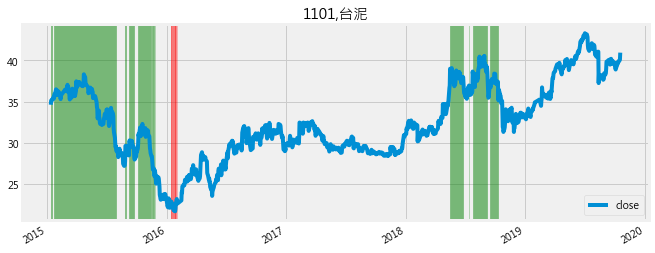

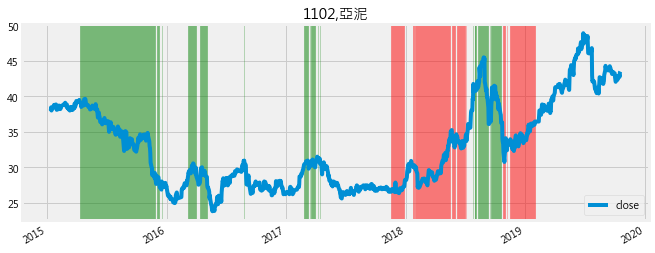

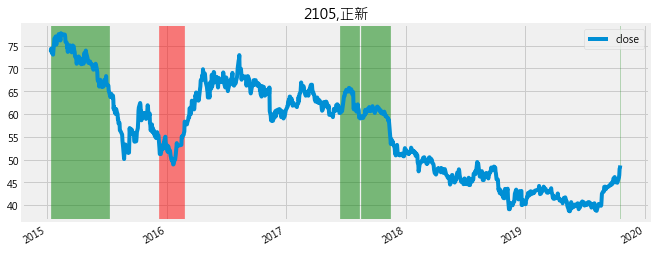

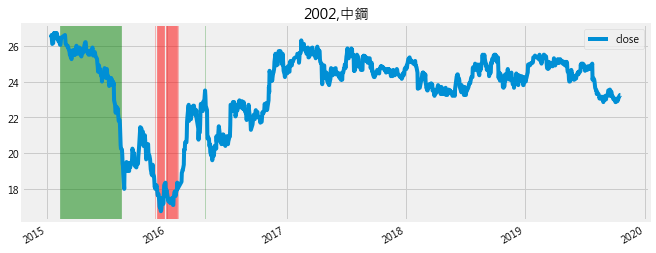

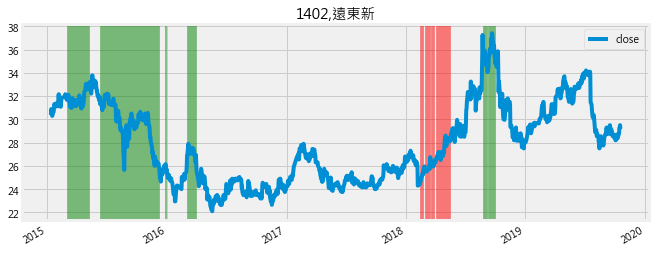

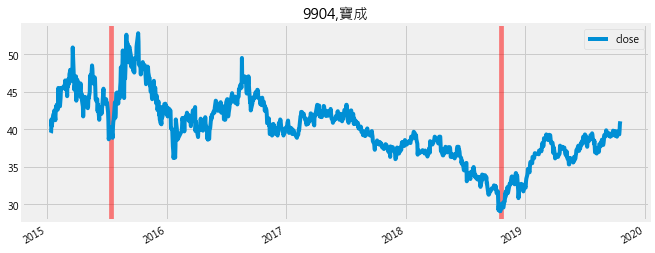

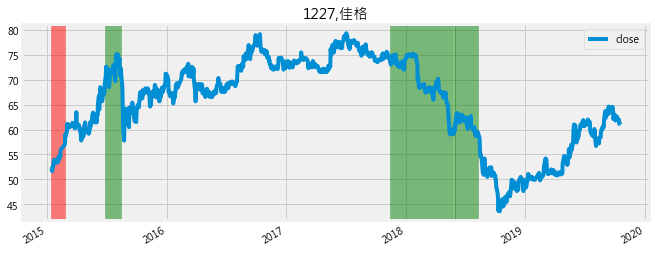

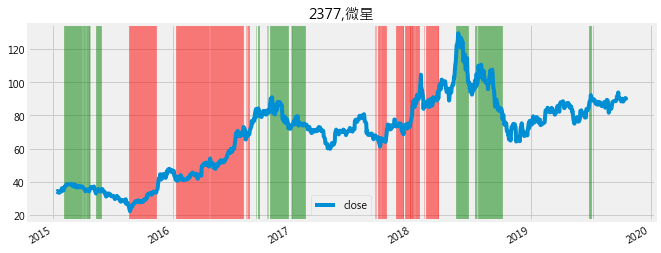

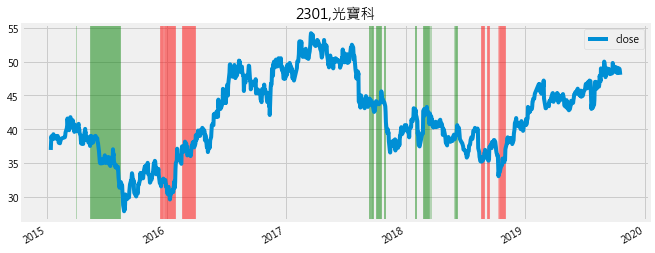

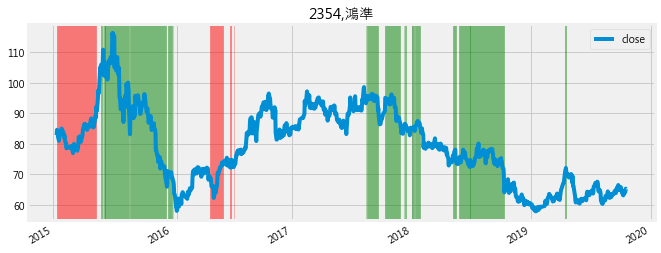

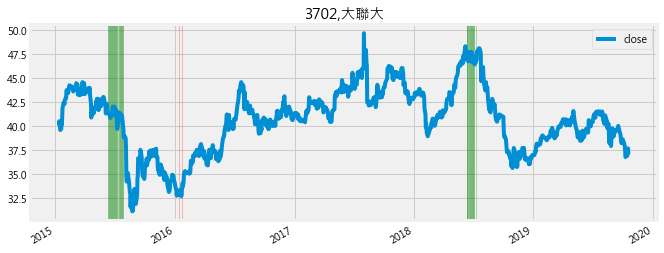

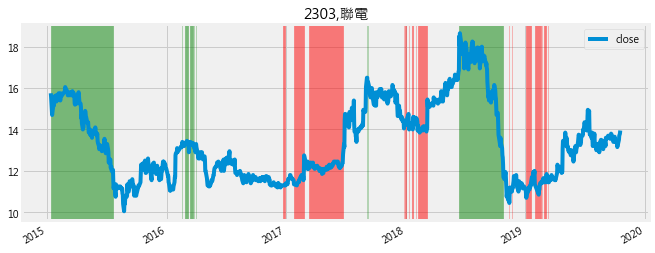

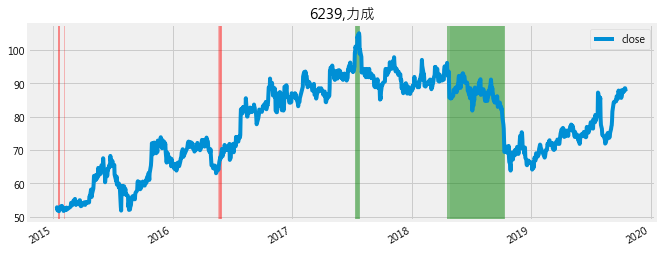

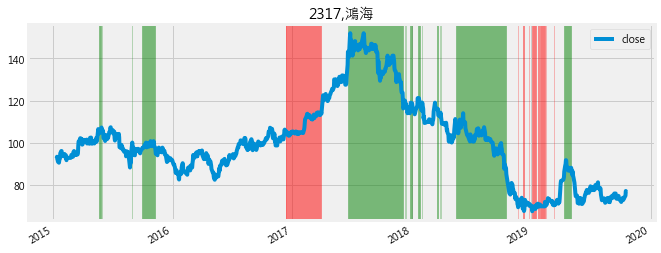

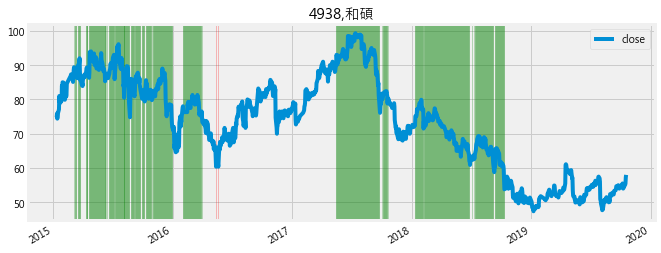

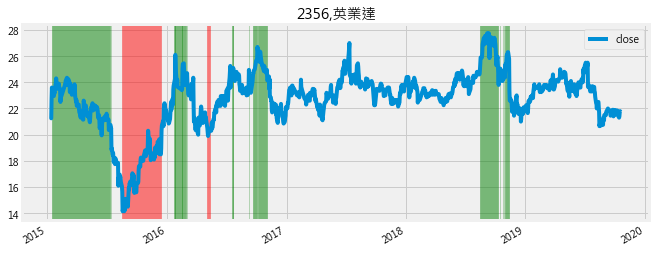

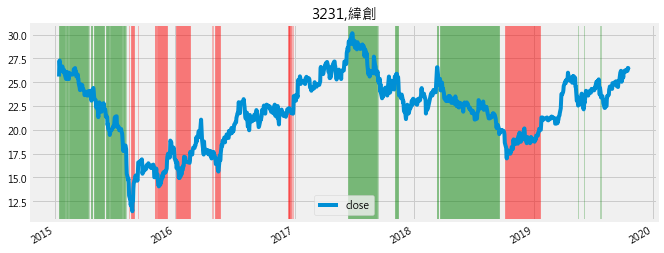

In [6]:
### plot
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('fivethirtyeight') # fivethirtyeight, fast
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # font to handle chinese
%matplotlib inline

def get_region(series):
    region = []
    get = False
    for i in range(len(series.index)):
        if series[i]:
            if not get:
                region.append([series.index[i]])
                get = True
            continue
        if get:
            region[-1].append(series.index[i - 1])
            get = False
    if len(region) > 0 and len(region[-1]) == 1:
        region[-1].append(series.index[-1])
    return region

def draw_region(region, ax, color):
    for xmin, xmax in region:
        ax.axvspan(xmin, xmax, color=color, alpha=0.5)
    
stock_info = db.get_stock_info()
for stock_id in stock_data:
    stock_name = stock_info.loc[stock_id, 'stock_name']
    df_daily_ori = stock_data[stock_id]#['2019']
    df_daily = df_daily_ori.copy()
    df_daily['label_buy'] = model_buy.predict(df_daily_ori)
    df_daily['label_sell'] = model_sell.predict(df_daily_ori)
    region_buy = get_region(df_daily['label_buy'])
    if len(region_buy) > 0:
        ax = df_daily[['close']].plot(grid=True, title=stock_id + ',' + stock_name, figsize=(10,4))
        draw_region(region_buy, ax, 'red')
        region_sell = get_region(df_daily['label_sell'])
        draw_region(region_sell, ax, 'green')